In [34]:
import pandas as pd
import numpy as np
import os


###############################################
# Merge population and World Bank data
###############################################
def merge_population_and_worldbank(pop_long_path='../processed_data/population_long_format.csv', 
                                   wb_path='../raw_data/WorldBank.csv'):
    """
    Merge long-format population data with World Bank data.
    
    Returns:
        df_merged : DataFrame with all population and World Bank indicators by country-year
    """
    
    # Load long-format population and World Bank data
    df_pop = pd.read_csv(pop_long_path)
    df_wb = pd.read_csv(wb_path)
    
    # Merge population with World Bank data on Country Code and Year
    df_merged = df_pop.merge(
        df_wb,
        left_on=['CCA3', 'Year'],
        right_on=['Country Code', 'Year'],
        how='inner'
    )
    
    # Reset index
    df_merged = df_merged.reset_index(drop=True)
    
    print(f"Merged data shape: {df_merged.shape}")
    print(f"Year range: {df_merged['Year'].min()} - {df_merged['Year'].max()}")
    print(f"Number of countries: {df_merged['CCA3'].nunique()}")
    print(f"Number of country-year observations: {len(df_merged)}\n")
    
    # Save merged data
    output_dir = '../processed_data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df_merged.to_csv(os.path.join(output_dir, 'merged_data.csv'), index=False)
    print(f"Merged data saved to {output_dir}/merged_data.csv\n")
    
    return df_merged


###############################################
# Select valuable features for prediction
###############################################
def select_features_for_prediction(df_merged):
    """
    Select valuable features from merged data for predicting population growth.
    
    Returns:
        X_features : DataFrame of selected features
        y : Target variable (population)
        meta : DataFrame with country and year identifiers
    """
    
    # Keep only rows with non-null population
    df_clean = df_merged[df_merged['Population'].notna()].copy()
    
    # Select valuable features for prediction
    feature_cols = [
        'Birth rate, crude (per 1,000 people)',
        'Death rate, crude (per 1,000 people)',
        'Life expectancy at birth (years)',
        'GDP per capita (USD)',
        'GDP (USD)',
        'Population density (people per sq. km of land area)',
        'Electric power consumption (kWh per capita)',
        'Individuals using the Internet (% of population)',
        'Infant mortality rate (per 1,000 live births)',
        'Unemployment (% of total labor force) (modeled ILO estimate)',
        'Growth Rate'
    ]
    
    # Create feature matrix with available columns
    X_features = pd.DataFrame()
    
    for col in feature_cols:
        if col in df_clean.columns:
            X_features[col] = df_clean[col]
    
    # Add temporal feature
    X_features['Year'] = df_clean['Year']
    
    # Add categorical features
    X_features['Region'] = df_clean['Region']
    X_features['IncomeGroup'] = df_clean['IncomeGroup']
    
    # Target variable: Population
    y = df_clean['Population'].values
    
    # Meta information for tracking
    meta = df_clean[['Country Name', 'CCA3', 'Region', 'IncomeGroup', 'Year']].copy()
    
    print(f"Selected features: {X_features.shape[1]} features")
    print(f"Observations: {X_features.shape[0]}")
    print(f"Missing values per column:")
    missing_pct = (X_features.isnull().sum() / len(X_features) * 100).round(2)
    for col in X_features.columns:
        if missing_pct[col] > 0:
            print(f"  {col}: {missing_pct[col]}%")
    print()
    
    return X_features, y, meta, df_clean


###############################################
# Prepare data for next-year predictions
###############################################
def prepare_for_next_year_prediction(df_merged, max_year_gap=10, prediction_horizons=[1, 2, 3, 5, 10]):
    """
    Prepare training data for predicting population growth rate.
    
    Creates multiple training pairs per country by predicting different year horizons
    (1, 2, 3, 5 years ahead). This significantly increases the number of datapoints.
    
    Args:
        df_merged : Merged population and World Bank data
        max_year_gap : Maximum gap between years to consider valid (default 10)
        prediction_horizons : List of years ahead to predict (default [1,2,3,5])
    
    Returns:
        X_train : Feature matrix for training
        y_train : Target growth rate values (percentage)
        meta_train : Metadata (country, year, prediction horizon)
    """
    
    # Sort by country and year
    df_sorted = df_merged.sort_values(['CCA3', 'Year']).reset_index(drop=True)
    
    # Keep only rows with population and key identifiers
    df_clean = df_sorted[df_sorted['Population'].notna()].copy()
    
    X_train_list = []
    y_train = []
    meta_train = []
    
    # For each country, create multiple prediction pairs
    for country in df_clean['CCA3'].unique():
        country_data = df_clean[df_clean['CCA3'] == country].sort_values('Year').reset_index(drop=True)
        
        # Skip if we don't have enough years
        if len(country_data) < 2:
            continue
        
        # For each year in the country data
        for i in range(len(country_data)):
            current_year = country_data.iloc[i]
            
            # Try to predict each horizon
            for horizon in prediction_horizons:
                # Find the future year closest to current_year + horizon
                target_year = current_year['Year'] + horizon
                future_rows = country_data[country_data['Year'] > current_year['Year']]
                
                if len(future_rows) == 0:
                    continue
                
                # Find the closest year within max_year_gap
                year_diffs = abs(future_rows['Year'] - target_year)
                valid_mask = year_diffs <= max_year_gap
                
                if not valid_mask.any():
                    continue
                
                # Get the closest valid future year
                closest_idx = year_diffs[valid_mask].idxmin()
                future_year = country_data.loc[closest_idx]
                actual_year_gap = future_year['Year'] - current_year['Year']
                
                # Calculate growth rate: (future - current) / current * 100
                current_pop = current_year['Population']
                future_pop = future_year['Population']
                growth_rate = ((future_pop - current_pop) / current_pop) * 100
                
                # Build feature row with available data
                feature_row = {
                    'Population': current_year['Population'],
                    'Birth rate': current_year.get('Birth rate, crude (per 1,000 people)', np.nan),
                    'Death rate': current_year.get('Death rate, crude (per 1,000 people)', np.nan),
                    'Life expectancy': current_year.get('Life expectancy at birth (years)', np.nan),
                    'GDP per capita': current_year.get('GDP per capita (USD)', np.nan),
                    'GDP': current_year.get('GDP (USD)', np.nan),
                    'Density': current_year.get('Population density (people per sq. km of land area)', np.nan),
                    'Year': current_year['Year'],
                    'Years ahead': actual_year_gap
                }
                
                X_train_list.append(feature_row)
                y_train.append(growth_rate)
                
                meta_train.append({
                    'Country Name': current_year['Country Name'],
                    'CCA3': current_year['CCA3'],
                    'Region': current_year.get('Region', 'Unknown'),
                    'IncomeGroup': current_year.get('IncomeGroup', 'Unknown'),
                    'Year': int(current_year['Year']),
                    'Next Year': int(future_year['Year']),
                    'Prediction Horizon': horizon
                })
    
    # Convert lists to DataFrames
    X_train = pd.DataFrame(X_train_list)
    y_train = np.array(y_train)
    meta_train = pd.DataFrame(meta_train)
    
    print(f"Training data prepared:")
    print(f"  Features shape: {X_train.shape}")
    print(f"  Target samples: {len(y_train)}")
    if len(meta_train) > 0:
        print(f"  Years covered: {meta_train['Year'].min()} to {meta_train['Year'].max()}")
        print(f"  Countries: {meta_train['CCA3'].nunique()}")
        print(f"  Prediction horizons used: {sorted(meta_train['Prediction Horizon'].unique())}\n")
    else:
        print("  No training data created!\n")
    
    return X_train, y_train, meta_train


# 1. Merge population and World Bank data
print("Merging population and World Bank data...")
df_merged = merge_population_and_worldbank()

# 2. Select valuable features
print("Selecting valuable features...")
X_features, y, meta, df_clean = select_features_for_prediction(df_merged)



# 3. Prepare data for next-year prediction
print("Preparing data for population growth rate prediction...")
# Include longer time horizons for better long-term predictions
X_train, y_train, meta_train = prepare_for_next_year_prediction(df_merged, prediction_horizons=[1, 2, 3, 5, 10, 15, 20])

Merging population and World Bank data...
Merged data shape: (1254, 25)
Year range: 1970 - 2015
Number of countries: 209
Number of country-year observations: 1254

Merged data saved to ../processed_data/merged_data.csv

Selecting valuable features...
Selected features: 14 features
Observations: 1254
Missing values per column:
  Birth rate, crude (per 1,000 people): 5.34%
  Death rate, crude (per 1,000 people): 5.5%
  Life expectancy at birth (years): 7.5%
  GDP per capita (USD): 16.59%
  GDP (USD): 16.59%
  Population density (people per sq. km of land area): 2.55%
  Electric power consumption (kWh per capita): 56.22%
  Individuals using the Internet (% of population): 35.57%
  Infant mortality rate (per 1,000 live births): 15.15%
  Unemployment (% of total labor force) (modeled ILO estimate): 55.74%

Preparing data for population growth rate prediction...
Training data prepared:
  Features shape: (7106, 9)
  Target samples: 7106
  Years covered: 1970 to 2010
  Countries: 209
  Predict

In [35]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [36]:
###############################################
# Train-Test Split
###############################################

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"\nTrain-Test Split Complete:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Test set ratio: {len(X_test)/(len(X_train)+len(X_test)):.2%}")


Train-Test Split Complete:
  Training samples: 5684
  Test samples: 1422
  Test set ratio: 20.01%


In [37]:
###############################################
# Model Training with Preprocessing Pipeline
###############################################

print("\n" + "="*70)
print("TRAINING MACHINE LEARNING MODELS")
print("="*70)

# Import KNNImputer for handling missing values
from sklearn.impute import KNNImputer

# Get numeric and categorical columns
numeric_features = ['Population', 'Birth rate', 'Death rate', 'Life expectancy', 
                   'GDP per capita', 'GDP', 'Density', 'Year', 'Years ahead']
categorical_features = []  # If you have any categorical features, add them here

# Create preprocessing pipeline with KNN imputer for missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),  # Fill NaN using 5 nearest neighbors
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])

# Store training columns for later use
training_columns = X_train.columns.tolist()

# Define models to train
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Train models and store results
results = {}

for model_name, pipeline in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store results
    results[model_name] = {
        'model': pipeline,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'predictions': y_test_pred,
        'y_test': y_test
    }
    
    print(f"  Train RMSE: {train_rmse:.2f}%")
    print(f"  Test RMSE:  {test_rmse:.2f}%")
    print(f"  Train MAE:  {train_mae:.2f}%")
    print(f"  Test MAE:   {test_mae:.2f}%")

# Select best model based on test RMSE
best_model_name = min(results.keys(), key=lambda k: results[k]['test_rmse'])
best_model_pipeline = results[best_model_name]['model']

print(f"\n" + "="*70)
print(f"BEST MODEL: {best_model_name}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f}%")
print("="*70)


TRAINING MACHINE LEARNING MODELS

Training Linear Regression...
  Train RMSE: 21.59%
  Test RMSE:  21.98%
  Train MAE:  10.31%
  Test MAE:   10.49%

Training Random Forest...
  Train RMSE: 21.59%
  Test RMSE:  21.98%
  Train MAE:  10.31%
  Test MAE:   10.49%

Training Random Forest...
  Train RMSE: 4.82%
  Test RMSE:  10.49%
  Train MAE:  0.81%
  Test MAE:   1.93%

Training Gradient Boosting...
  Train RMSE: 4.82%
  Test RMSE:  10.49%
  Train MAE:  0.81%
  Test MAE:   1.93%

Training Gradient Boosting...
  Train RMSE: 10.39%
  Test RMSE:  13.93%
  Train MAE:  6.13%
  Test MAE:   6.57%

BEST MODEL: Random Forest
Test RMSE: 10.49%
  Train RMSE: 10.39%
  Test RMSE:  13.93%
  Train MAE:  6.13%
  Test MAE:   6.57%

BEST MODEL: Random Forest
Test RMSE: 10.49%



DATA VISUALIZATION


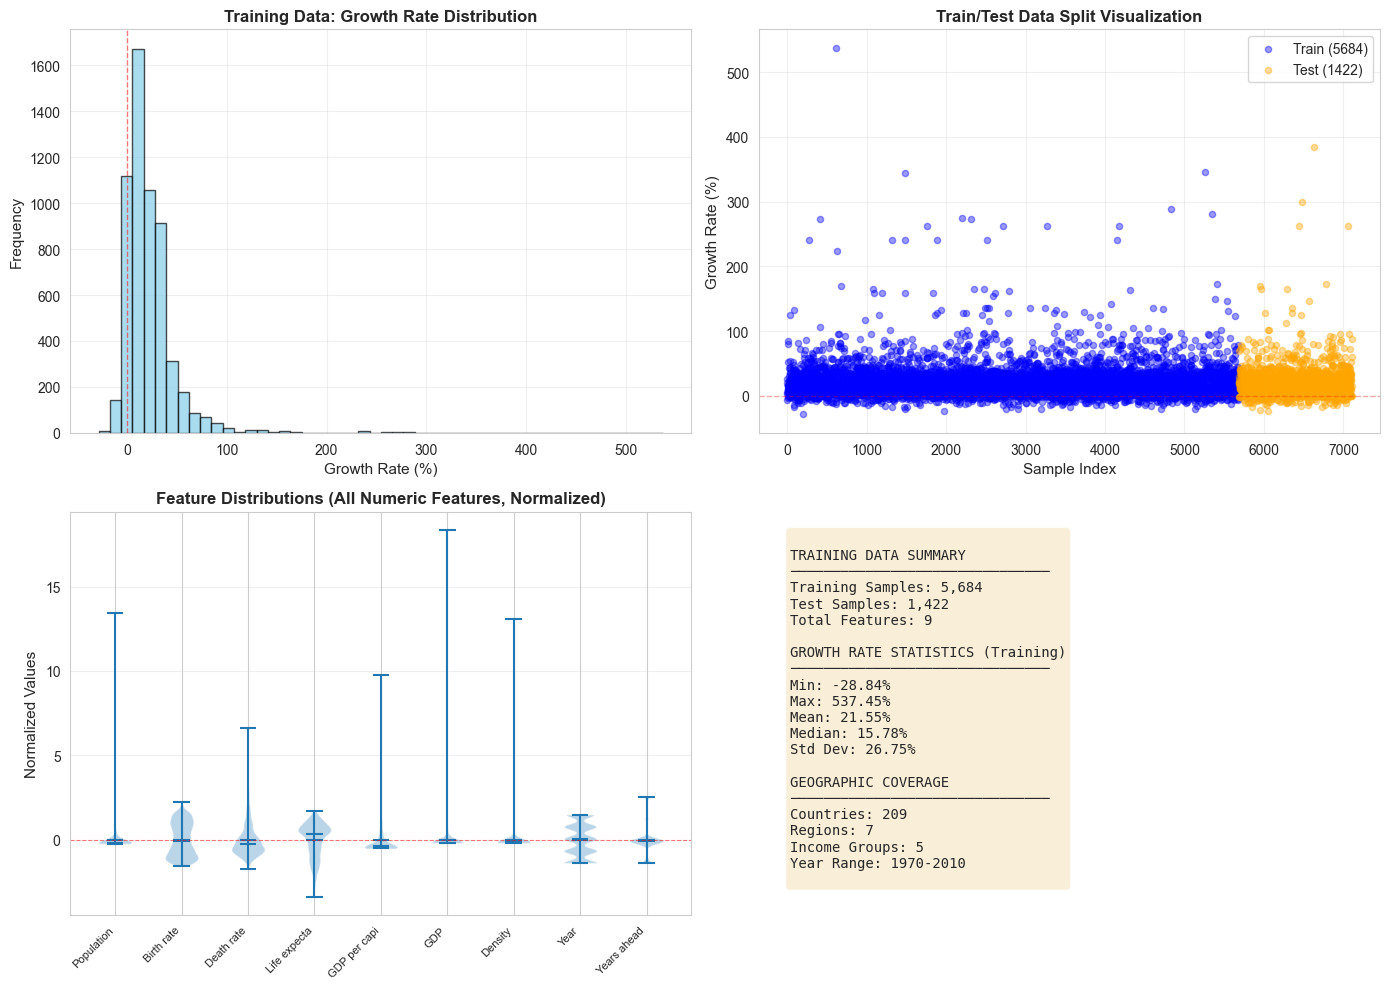


Data visualization saved to '../processed_data/data_visualization.png'


In [38]:
###############################################
# Data Visualization
###############################################

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("\n" + "="*70)
print("DATA VISUALIZATION")
print("="*70)

# 1. Target variable distribution and statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Growth rate distribution
axes[0, 0].hist(y_train, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Growth Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Training Data: Growth Rate Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero Growth')

# Train vs Test split visualization
axes[0, 1].scatter(range(len(y_train)), y_train, alpha=0.4, s=20, label=f'Train ({len(y_train)})', color='blue')
axes[0, 1].scatter(range(len(y_train), len(y_train) + len(y_test)), y_test, alpha=0.4, s=20, label=f'Test ({len(y_test)})', color='orange')
axes[0, 1].set_xlabel('Sample Index', fontsize=11)
axes[0, 1].set_ylabel('Growth Rate (%)', fontsize=11)
axes[0, 1].set_title('Train/Test Data Split Visualization', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.3)

# Feature distributions - show all numeric features
X_train_display = X_train.copy()
# Select only numeric columns
numeric_cols = X_train_display.select_dtypes(include=[np.number]).columns.tolist()
X_train_numeric = X_train_display[numeric_cols].copy()

# Create a more comprehensive feature distribution visualization
# Use violin plot to show distribution shape
num_features = len(numeric_cols)
if num_features > 0:
    # Normalize for better visualization
    X_train_normalized = (X_train_numeric - X_train_numeric.mean()) / X_train_numeric.std()
    
    # Create violin plot with all features
    parts = axes[1, 0].violinplot(
        [X_train_normalized[col].dropna().values for col in numeric_cols],
        positions=range(num_features),
        showmeans=True,
        showmedians=True
    )
    
    axes[1, 0].set_xticks(range(num_features))
    axes[1, 0].set_xticklabels([col[:12] for col in numeric_cols], rotation=45, ha='right', fontsize=8)
    axes[1, 0].set_ylabel('Normalized Values', fontsize=11)
    axes[1, 0].set_title('Feature Distributions (All Numeric Features, Normalized)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Data summary statistics
axes[1, 1].axis('off')
summary_text = f"""
TRAINING DATA SUMMARY
───────────────────────────────
Training Samples: {len(y_train):,}
Test Samples: {len(y_test):,}
Total Features: {X_train.shape[1]}

GROWTH RATE STATISTICS (Training)
───────────────────────────────
Min: {y_train.min():.2f}%
Max: {y_train.max():.2f}%
Mean: {y_train.mean():.2f}%
Median: {np.median(y_train):.2f}%
Std Dev: {y_train.std():.2f}%

GEOGRAPHIC COVERAGE
───────────────────────────────
Countries: {meta_train['CCA3'].nunique()}
Regions: {meta_train['Region'].nunique()}
Income Groups: {meta_train['IncomeGroup'].nunique()}
Year Range: {meta_train['Year'].min()}-{meta_train['Year'].max()}
"""
axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../processed_data/data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nData visualization saved to '../processed_data/data_visualization.png'")



MODEL PERFORMANCE VISUALIZATION


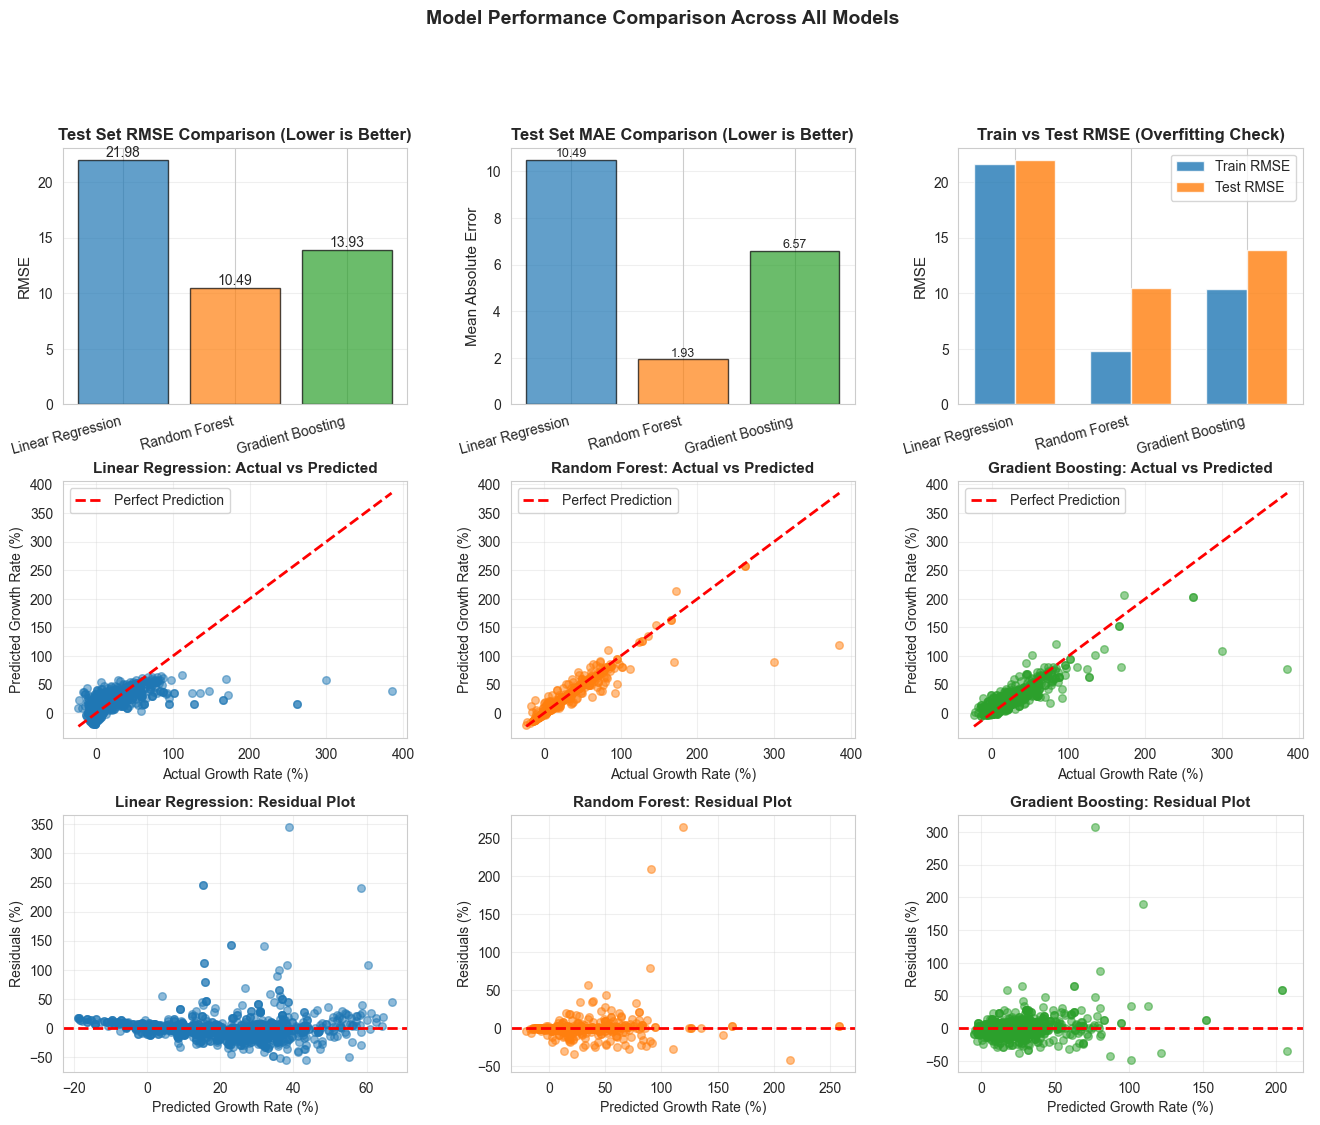

Model performance visualization saved to '../processed_data/model_performance.png'

DETAILED PERFORMANCE METRICS

Linear Regression:
  Train MAE:  10.31%
  Test MAE:   10.49%
  Train RMSE: 21.59%
  Test RMSE:  21.98%
  Mean Residual: -0.36%
  Std Residual:  21.98%

Random Forest:
  Train MAE:  0.81%
  Test MAE:   1.93%
  Train RMSE: 4.82%
  Test RMSE:  10.49%
  Mean Residual: 0.34%
  Std Residual:  10.48%

Gradient Boosting:
  Train MAE:  6.13%
  Test MAE:   6.57%
  Train RMSE: 10.39%
  Test RMSE:  13.93%
  Mean Residual: 0.11%
  Std Residual:  13.92%


In [39]:
###############################################
# Model Visualization - Learning Curves & Performance
###############################################

print("\n" + "="*70)
print("MODEL PERFORMANCE VISUALIZATION")
print("="*70)

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Color palette for models
colors = {'Linear Regression': '#1f77b4', 'Random Forest': '#ff7f0e', 'Gradient Boosting': '#2ca02c'}
model_names = list(results.keys())

# 1. Model Comparison - Test RMSE scores
ax1 = fig.add_subplot(gs[0, 0])
test_rmse_scores = [results[m]['test_rmse'] for m in model_names]
bars = ax1.bar(model_names, test_rmse_scores, color=[colors[m] for m in model_names], edgecolor='black', alpha=0.7)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title('Test Set RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 2. Model Comparison - Test MAE scores
ax2 = fig.add_subplot(gs[0, 1])
test_mae_scores = [results[m]['test_mae'] for m in model_names]
bars = ax2.bar(model_names, test_mae_scores, color=[colors[m] for m in model_names], edgecolor='black', alpha=0.7)
ax2.set_ylabel('Mean Absolute Error', fontsize=11)
ax2.set_title('Test Set MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3. Train vs Test RMSE - all models
ax3 = fig.add_subplot(gs[0, 2])
x_pos = np.arange(len(model_names))
width = 0.35
train_rmse = [results[m]['train_rmse'] for m in model_names]
test_rmse = [results[m]['test_rmse'] for m in model_names]
ax3.bar(x_pos - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
ax3.bar(x_pos + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
ax3.set_ylabel('RMSE', fontsize=11)
ax3.set_title('Train vs Test RMSE (Overfitting Check)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(model_names, rotation=15, ha='right')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4-6. Prediction Accuracy plots for each model (Actual vs Predicted)
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[1, idx])
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    
    # Scatter plot: Actual vs Predicted
    ax.scatter(y_actual, y_pred, alpha=0.5, s=30, color=colors[model_name])
    
    # Perfect prediction line
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Growth Rate (%)', fontsize=10)
    ax.set_ylabel('Predicted Growth Rate (%)', fontsize=10)
    ax.set_title(f'{model_name}: Actual vs Predicted', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

# 7-9. Residual plots for each model
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[2, idx])
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    residuals = y_actual - y_pred
    
    # Residual plot
    ax.scatter(y_pred, residuals, alpha=0.5, s=30, color=colors[model_name])
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted Growth Rate (%)', fontsize=10)
    ax.set_ylabel('Residuals (%)', fontsize=10)
    ax.set_title(f'{model_name}: Residual Plot', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

plt.suptitle('Model Performance Comparison Across All Models', fontsize=14, fontweight='bold', y=0.995)
plt.savefig('../processed_data/model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Model performance visualization saved to '../processed_data/model_performance.png'")

# Print detailed performance metrics table
print("\n" + "="*70)
print("DETAILED PERFORMANCE METRICS")
print("="*70)
for model_name in model_names:
    print(f"\n{model_name}:")
    print(f"  Train MAE:  {results[model_name]['train_mae']:.2f}%")
    print(f"  Test MAE:   {results[model_name]['test_mae']:.2f}%")
    print(f"  Train RMSE: {results[model_name]['train_rmse']:.2f}%")
    print(f"  Test RMSE:  {results[model_name]['test_rmse']:.2f}%")
    
    # Calculate residual statistics
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    residuals = y_actual - y_pred
    print(f"  Mean Residual: {np.mean(residuals):.2f}%")
    print(f"  Std Residual:  {np.std(residuals):.2f}%")



FEATURE IMPORTANCE ANALYSIS (SHAP VALUES)

Computing SHAP values for Gradient Boosting model...
This may take a moment...
(Analyzing which features most influence growth rate predictions)



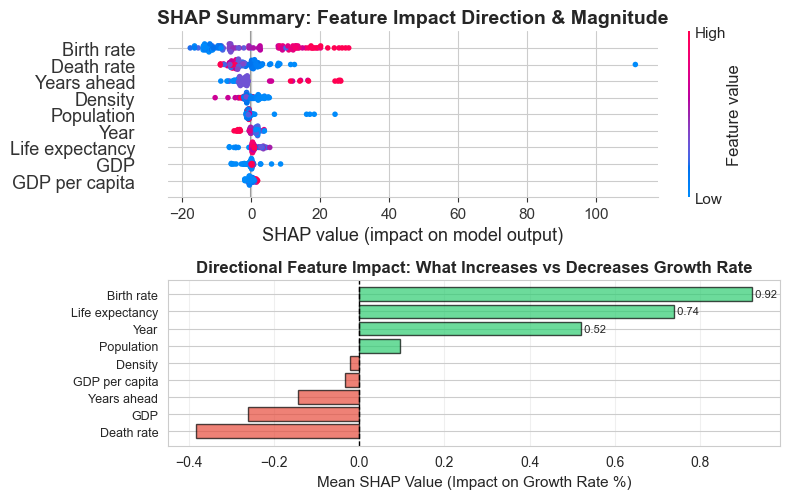

SHAP importance plot saved to '../processed_data/shap_importance.png'

DIRECTIONAL FEATURE IMPACTS ON GROWTH RATE

FEATURES THAT INCREASE GROWTH RATE (Positive Mean SHAP):
----------------------------------------------------------------------
  Birth rate                     : +  0.9212 (pushes predictions UP)
  Life expectancy                : +  0.7379 (pushes predictions UP)
  Year                           : +  0.5197 (pushes predictions UP)
  Population                     : +  0.0951 (pushes predictions UP)

FEATURES THAT DECREASE GROWTH RATE (Negative Mean SHAP):
----------------------------------------------------------------------
  Density                        :  -0.0225 (pushes predictions DOWN)
  GDP per capita                 :  -0.0336 (pushes predictions DOWN)
  Years ahead                    :  -0.1441 (pushes predictions DOWN)
  GDP                            :  -0.2605 (pushes predictions DOWN)
  Death rate                     :  -0.3828 (pushes predictions DOWN)

S

In [40]:
###############################################
# SHAP Values - Feature Importance Analysis
###############################################
import shap

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS (SHAP VALUES)")
print("="*70)


# Use the best performing model (Gradient Boosting) for SHAP analysis
best_model_pipeline = models['Gradient Boosting']
# Extract the actual model from the pipeline
best_model = best_model_pipeline.named_steps['model']

print("\nComputing SHAP values for Gradient Boosting model...")
print("This may take a moment...")
print("(Analyzing which features most influence growth rate predictions)\n")

# Create SHAP explainer
# Use a sample of training data for faster computation
sample_size = min(100, len(X_train))
sample_idx = np.random.RandomState(42).choice(len(X_train), size=sample_size, replace=False)
X_sample = X_train.iloc[sample_idx]

# Preprocess the sample data using the pipeline's preprocessor
X_sample_preprocessed = best_model_pipeline.named_steps['preprocessor'].transform(X_sample)
X_sample_preprocessed_df = pd.DataFrame(X_sample_preprocessed, columns=X_sample.columns)

# TreeExplainer is most efficient for tree-based models
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample_preprocessed_df)

# Create SHAP visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. Summary plot (dot plot) - shows distribution and direction of SHAP values
plt.sca(axes[0])
shap.summary_plot(shap_values, X_sample_preprocessed_df, show=False)
axes[0].set_title('SHAP Summary: Feature Impact Direction & Magnitude', fontsize=14, fontweight='bold')

# 2. Mean SHAP values (directional) - what pushes predictions up vs down
plt.sca(axes[1])
mean_shap = shap_values.mean(axis=0)
feature_names = X_sample_preprocessed_df.columns

# Sort by mean SHAP value
sorted_idx = np.argsort(mean_shap)
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_values = mean_shap[sorted_idx]

# Create horizontal bar chart with colors
colors_bar = ['#e74c3c' if val < 0 else '#2ecc71' for val in sorted_values]
y_pos = np.arange(len(sorted_features))

axes[1].barh(y_pos, sorted_values, color=colors_bar, edgecolor='black', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(sorted_features, fontsize=9)
axes[1].set_xlabel('Mean SHAP Value (Impact on Growth Rate %)', fontsize=11)
axes[1].set_title('Directional Feature Impact: What Increases vs Decreases Growth Rate', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

# Add text annotations for extreme values
for i, (feat, val) in enumerate(zip(sorted_features, sorted_values)):
    if abs(val) > 0.5:  # Only annotate significant features
        axes[1].text(val, i, f' {val:.2f}', va='center', 
                    ha='left' if val > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('../processed_data/shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("SHAP importance plot saved to '../processed_data/shap_importance.png'")

# Print directional feature impacts
print("\n" + "="*70)
print("DIRECTIONAL FEATURE IMPACTS ON GROWTH RATE")
print("="*70)

# Calculate mean SHAP values (directional)
mean_shap_values = shap_values.mean(axis=0)
feature_impact_df = pd.DataFrame({
    'Feature': X_sample_preprocessed_df.columns,
    'Mean SHAP': mean_shap_values,
    'Impact': ['Increases Growth' if x > 0 else 'Decreases Growth' for x in mean_shap_values]
}).sort_values('Mean SHAP', ascending=False)

print("\nFEATURES THAT INCREASE GROWTH RATE (Positive Mean SHAP):")
print("-" * 70)
positive_features = feature_impact_df[feature_impact_df['Mean SHAP'] > 0]
if len(positive_features) > 0:
    for idx, row in positive_features.iterrows():
        print(f"  {row['Feature']:30s} : +{row['Mean SHAP']:8.4f} (pushes predictions UP)")
else:
    print("  None")

print("\nFEATURES THAT DECREASE GROWTH RATE (Negative Mean SHAP):")
print("-" * 70)
negative_features = feature_impact_df[feature_impact_df['Mean SHAP'] < 0]
if len(negative_features) > 0:
    for idx, row in negative_features.iterrows():
        print(f"  {row['Feature']:30s} : {row['Mean SHAP']:8.4f} (pushes predictions DOWN)")
else:
    print("  None")

print("\n" + "="*70)
print("SHAP VALUE INTERPRETATION")
print("="*70)
print("""
SHAP (SHapley Additive exPlanations) values show directional feature impacts:

POSITIVE Mean SHAP = Feature pushes growth rate predictions UP on average
    Example: If "Birth rate" has +2.5, it increases predicted growth rates

NEGATIVE Mean SHAP = Feature pulls growth rate predictions DOWN on average
    Example: If "Death rate" has -1.8, it decreases predicted growth rates

- The MAGNITUDE shows how strong the push/pull effect is
- In the dot plot: Red = high feature values, Blue = low feature values
- Dots to the RIGHT increase prediction, dots to the LEFT decrease it

This reveals what drives population growth vs what slows it down according to the model.
""")



In [41]:
###############################################
# Prepare 2015 baseline data for future predictions
###############################################

print("\n" + "="*70)
print("PREPARING 2015 BASELINE DATA FOR PREDICTIONS")
print("="*70)

# Filter for 2015 data (baseline year)
df_merged_2015 = df_merged[df_merged['Year'] == 2015].copy()

print(f"\nCountries with 2015 data: {len(df_merged_2015)}")
print(f"Columns available: {df_merged_2015.shape[1]}")

# Helper function to make predictions for a target year
def predict_population_for_year(df_baseline, target_year, model_pipeline, training_columns):
    """
    Predict population for a target year based on baseline data.
    
    Args:
        df_baseline: DataFrame with baseline year data
        target_year: Year to predict (e.g., 2025, 2030, 2035)
        model_pipeline: Trained model pipeline (includes preprocessing)
        training_columns: List of column names used in training
    
    Returns:
        DataFrame with predictions and metadata
    """
    baseline_year = df_baseline['Year'].iloc[0]
    years_ahead = target_year - baseline_year
    
    X_pred_list = []
    meta_pred_list = []
    
    for idx, row in df_baseline.iterrows():
        feature_row = {
            'Population': row['Population'],
            'Birth rate': row.get('Birth rate, crude (per 1,000 people)', np.nan),
            'Death rate': row.get('Death rate, crude (per 1,000 people)', np.nan),
            'Life expectancy': row.get('Life expectancy at birth (years)', np.nan),
            'GDP per capita': row.get('GDP per capita (USD)', np.nan),
            'GDP': row.get('GDP (USD)', np.nan),
            'Density': row.get('Population density (people per sq. km of land area)', np.nan),
            'Year': baseline_year,
            'Years ahead': years_ahead
        }
        
        X_pred_list.append(feature_row)
        meta_pred_list.append({
            'Country Name': row['Country Name'],
            'CCA3': row['CCA3'],
            'Region': row.get('Region', 'Unknown'),
            'IncomeGroup': row.get('IncomeGroup', 'Unknown'),
            f'Population_{baseline_year}': row['Population']
        })
    
    X_pred = pd.DataFrame(X_pred_list)
    meta_pred = pd.DataFrame(meta_pred_list)
    
    # Reorder to match training columns
    X_pred = X_pred[training_columns]
    
    # Predict growth rates using the pipeline (which includes preprocessing)
    # The pipeline will handle missing values through its imputer
    predicted_growth_rates = model_pipeline.predict(X_pred)
    
    # Calculate predicted population
    meta_pred['Predicted_Growth_Rate'] = predicted_growth_rates
    meta_pred[f'Predicted_Population_{target_year}'] = meta_pred[f'Population_{baseline_year}'] * (1 + predicted_growth_rates / 100)
    
    return meta_pred, predicted_growth_rates

# Make predictions for 2025, 2030, 2035
print("\nGenerating predictions for multiple years...")

# 2025 predictions (10 years ahead)
meta_2025, growth_2025 = predict_population_for_year(df_merged_2015, 2025, best_model_pipeline, training_columns)
meta_2025.to_csv('../processed_data/population_predictions_2025.csv', index=False)
print(f"2025 predictions saved: Avg growth = {growth_2025.mean():.2f}%")

# 2030 predictions (15 years ahead)
meta_2030, growth_2030 = predict_population_for_year(df_merged_2015, 2030, best_model_pipeline, training_columns)
meta_2030.to_csv('../processed_data/population_predictions_2030.csv', index=False)
print(f"2030 predictions saved: Avg growth = {growth_2030.mean():.2f}%")

print("\nAll prediction files generated successfully!")


PREPARING 2015 BASELINE DATA FOR PREDICTIONS

Countries with 2015 data: 209
Columns available: 25

Generating predictions for multiple years...
2025 predictions saved: Avg growth = 11.16%
2030 predictions saved: Avg growth = 18.81%

All prediction files generated successfully!



PREDICTING 2025 POPULATION FROM 2015 DATA

Predictions generated for 2025
  Average predicted growth rate: 11.16%
  Growth rate range: -5.63% to 50.10%

Predictions saved to '../processed_data/population_predictions_2025.csv'


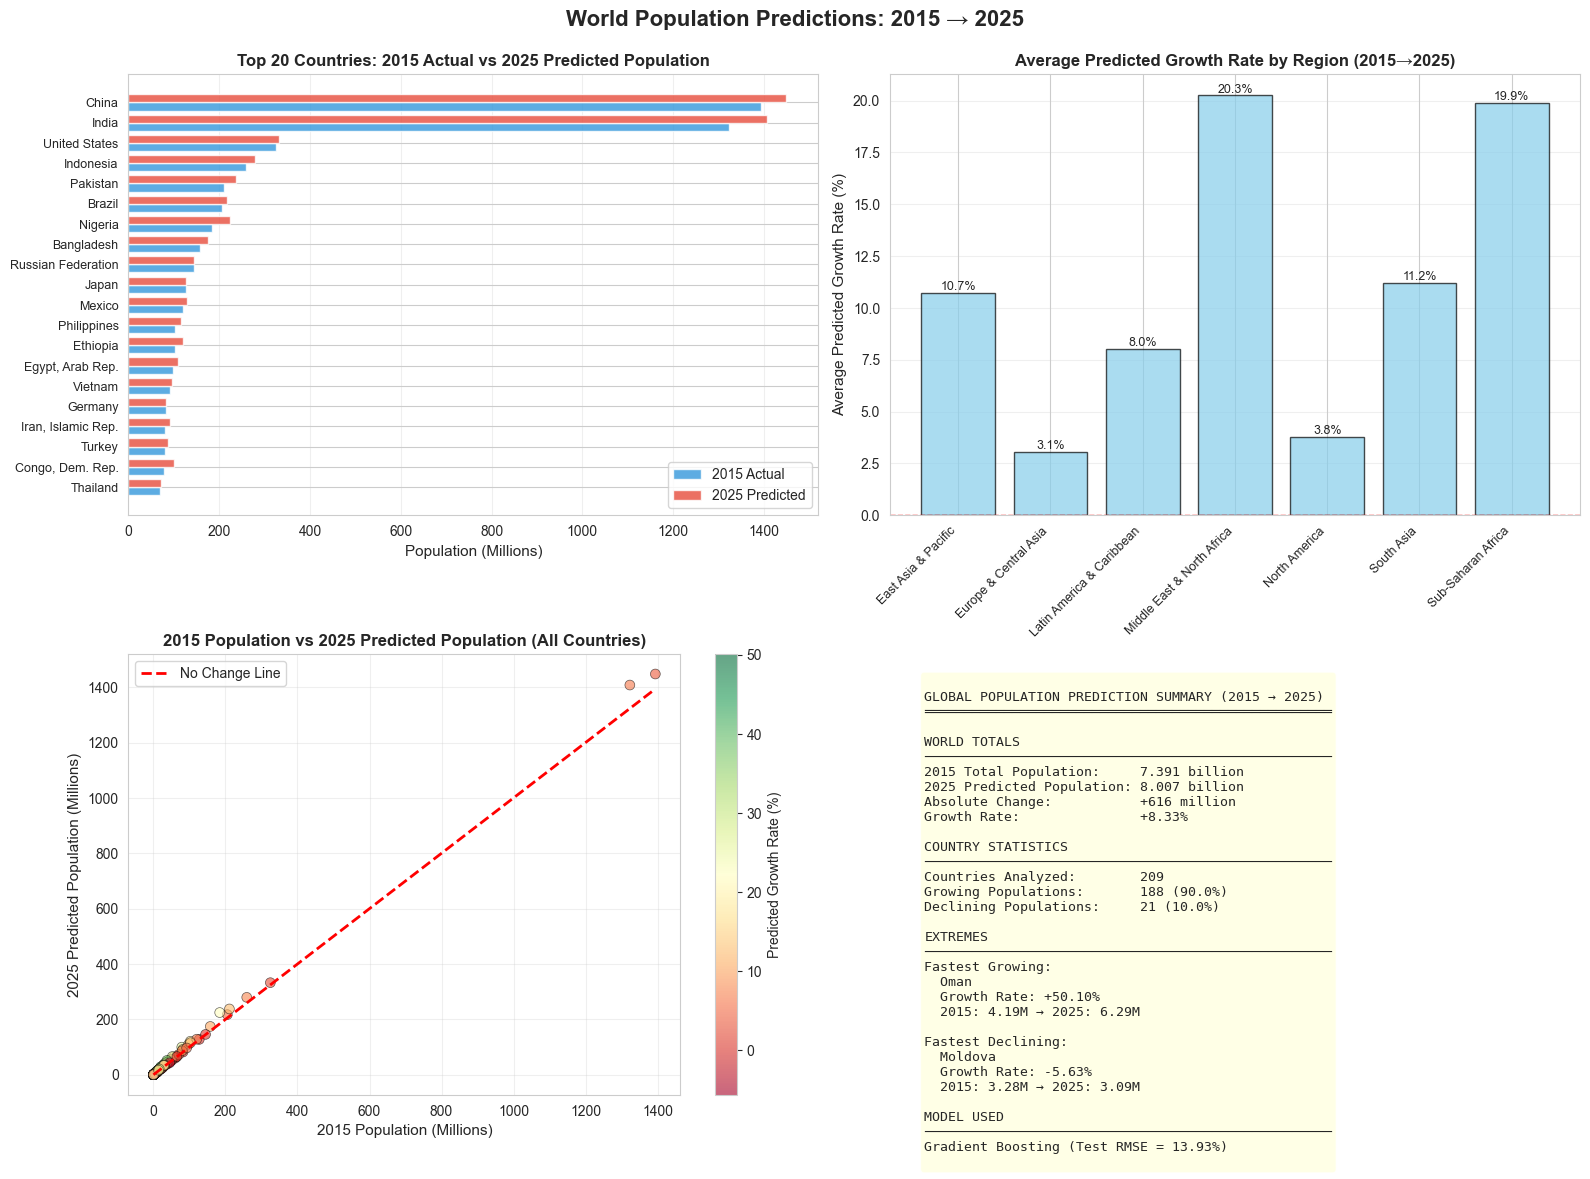


Visualization saved to '../processed_data/population_prediction_2015_2025.png'

TOP 10 COUNTRIES BY 2015 POPULATION - 2025 PREDICTIONS

Rank  Country                   2015 (M)     2025 (M)     Growth %  
----------------------------------------------------------------------
1     China                        1393.72     1447.52      3.86%
2     India                        1322.87     1407.62      6.41%
3     United States                 324.61      332.49      2.43%
4     Indonesia                     259.09      279.46      7.86%
5     Pakistan                      210.97      237.55     12.60%
6     Brazil                        205.19      217.06      5.78%
7     Nigeria                       184.00      224.59     22.06%
8     Bangladesh                    157.83      174.32     10.45%
9     Russian Federation            144.67      145.60      0.64%
10    Japan                         127.25      127.55      0.24%


In [42]:
###############################################
# 2015 vs 2025 Population Prediction
###############################################

print("\n" + "="*70)
print("PREDICTING 2025 POPULATION FROM 2015 DATA")
print("="*70)

# Use 2015 data to predict 2025 (10 years ahead)
X_2025_list = []
meta_2025_list = []

for idx, row in df_merged_2015.iterrows():
    feature_row = {
        'Population': row['Population'],
        'Birth rate': row.get('Birth rate, crude (per 1,000 people)', np.nan),
        'Death rate': row.get('Death rate, crude (per 1,000 people)', np.nan),
        'Life expectancy': row.get('Life expectancy at birth (years)', np.nan),
        'GDP per capita': row.get('GDP per capita (USD)', np.nan),
        'GDP': row.get('GDP (USD)', np.nan),
        'Density': row.get('Population density (people per sq. km of land area)', np.nan),
        'Year': 2015,
        'Years ahead': 10  # Predicting 10 years into the future
    }
    
    X_2025_list.append(feature_row)
    meta_2025_list.append({
        'Country Name': row['Country Name'],
        'CCA3': row['CCA3'],
        'Region': row.get('Region', 'Unknown'),
        'Population_2015': row['Population']
    })

X_2025 = pd.DataFrame(X_2025_list)
meta_2025 = pd.DataFrame(meta_2025_list)

# Reorder X_2025 to match training data columns
X_2025 = X_2025[training_columns]

# Use the best model pipeline to predict growth rate for 2025
predicted_growth_rates_2025 = best_model_pipeline.predict(X_2025)

# Calculate predicted 2025 population from growth rate
meta_2025['Predicted_Growth_Rate_2025'] = predicted_growth_rates_2025
meta_2025['Predicted_Population_2025'] = meta_2025['Population_2015'] * (1 + predicted_growth_rates_2025 / 100)

print(f"\nPredictions generated for 2025")
print(f"  Average predicted growth rate: {predicted_growth_rates_2025.mean():.2f}%")
print(f"  Growth rate range: {predicted_growth_rates_2025.min():.2f}% to {predicted_growth_rates_2025.max():.2f}%")

# Save predictions
meta_2025.to_csv('../processed_data/population_predictions_2025.csv', index=False)
print(f"\nPredictions saved to '../processed_data/population_predictions_2025.csv'")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 countries by 2015 population - comparing 2015 vs predicted 2025
top_20_2025 = meta_2025.nlargest(20, 'Population_2015').sort_values('Population_2015', ascending=True)
y_pos = np.arange(len(top_20_2025))

ax1 = axes[0, 0]
ax1.barh(y_pos - 0.2, top_20_2025['Population_2015'] / 1e6, 0.4, label='2015 Actual', color='#3498db', alpha=0.8)
ax1.barh(y_pos + 0.2, top_20_2025['Predicted_Population_2025'] / 1e6, 0.4, label='2025 Predicted', color='#e74c3c', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_20_2025['Country Name'], fontsize=9)
ax1.set_xlabel('Population (Millions)', fontsize=11)
ax1.set_title('Top 20 Countries: 2015 Actual vs 2025 Predicted Population', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3, axis='x')

# 2. Growth rate by region
ax2 = axes[0, 1]
regions_2025 = meta_2025.groupby('Region').agg({
    'Population_2015': 'sum',
    'Predicted_Population_2025': 'sum',
    'Predicted_Growth_Rate_2025': 'mean'
}).reset_index()
regions_2025['Absolute_Growth'] = regions_2025['Predicted_Population_2025'] - regions_2025['Population_2015']

x_pos_region = np.arange(len(regions_2025))
bars = ax2.bar(x_pos_region, regions_2025['Predicted_Growth_Rate_2025'], color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xticks(x_pos_region)
ax2.set_xticklabels(regions_2025['Region'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Average Predicted Growth Rate (%)', fontsize=11)
ax2.set_title('Average Predicted Growth Rate by Region (2015→2025)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)

for bar, val in zip(bars, regions_2025['Predicted_Growth_Rate_2025']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

# 3. Scatter plot - 2015 vs 2025 population
ax3 = axes[1, 0]
scatter = ax3.scatter(meta_2025['Population_2015'] / 1e6, 
                     meta_2025['Predicted_Population_2025'] / 1e6,
                     c=meta_2025['Predicted_Growth_Rate_2025'],
                     cmap='RdYlGn', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.plot([0, meta_2025['Population_2015'].max() / 1e6], 
         [0, meta_2025['Population_2015'].max() / 1e6], 
         'r--', linewidth=2, label='No Change Line')
ax3.set_xlabel('2015 Population (Millions)', fontsize=11)
ax3.set_ylabel('2025 Predicted Population (Millions)', fontsize=11)
ax3.set_title('2015 Population vs 2025 Predicted Population (All Countries)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Predicted Growth Rate (%)', fontsize=10)

# 4. Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')

total_2015 = meta_2025['Population_2015'].sum()
total_2025 = meta_2025['Predicted_Population_2025'].sum()
total_growth_2025 = ((total_2025 - total_2015) / total_2015) * 100

countries_growing_2025 = (meta_2025['Predicted_Growth_Rate_2025'] > 0).sum()
countries_declining_2025 = (meta_2025['Predicted_Growth_Rate_2025'] < 0).sum()

fastest_growing_2025 = meta_2025.nlargest(1, 'Predicted_Growth_Rate_2025').iloc[0]
fastest_declining_2025 = meta_2025.nsmallest(1, 'Predicted_Growth_Rate_2025').iloc[0]

summary_text = f"""
GLOBAL POPULATION PREDICTION SUMMARY (2015 → 2025)
═══════════════════════════════════════════════════

WORLD TOTALS
───────────────────────────────────────────────────
2015 Total Population:     {total_2015/1e9:.3f} billion
2025 Predicted Population: {total_2025/1e9:.3f} billion
Absolute Change:           {(total_2025-total_2015)/1e6:+,.0f} million
Growth Rate:               {total_growth_2025:+.2f}%

COUNTRY STATISTICS
───────────────────────────────────────────────────
Countries Analyzed:        {len(meta_2025)}
Growing Populations:       {countries_growing_2025} ({countries_growing_2025/len(meta_2025)*100:.1f}%)
Declining Populations:     {countries_declining_2025} ({countries_declining_2025/len(meta_2025)*100:.1f}%)

EXTREMES
───────────────────────────────────────────────────
Fastest Growing:
  {fastest_growing_2025['Country Name'][:30]}
  Growth Rate: {fastest_growing_2025['Predicted_Growth_Rate_2025']:+.2f}%
  2015: {fastest_growing_2025['Population_2015']/1e6:.2f}M → 2025: {fastest_growing_2025['Predicted_Population_2025']/1e6:.2f}M

Fastest Declining:
  {fastest_declining_2025['Country Name'][:30]}
  Growth Rate: {fastest_declining_2025['Predicted_Growth_Rate_2025']:+.2f}%
  2015: {fastest_declining_2025['Population_2015']/1e6:.2f}M → 2025: {fastest_declining_2025['Predicted_Population_2025']/1e6:.2f}M

MODEL USED
───────────────────────────────────────────────────
Gradient Boosting (Test RMSE = {results['Gradient Boosting']['test_rmse']:.2f}%)
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=9.5, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('World Population Predictions: 2015 → 2025', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../processed_data/population_prediction_2015_2025.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to '../processed_data/population_prediction_2015_2025.png'")

# Print top 10 predictions
print("\n" + "="*70)
print("TOP 10 COUNTRIES BY 2015 POPULATION - 2025 PREDICTIONS")
print("="*70)
top_10_2025 = meta_2025.nlargest(10, 'Population_2015')
print(f"\n{'Rank':<5} {'Country':<25} {'2015 (M)':<12} {'2025 (M)':<12} {'Growth %':<10}")
print("-" * 70)
for i, (idx, row) in enumerate(top_10_2025.iterrows(), 1):
    print(f"{i:<5} {row['Country Name'][:24]:<25} {row['Population_2015']/1e6:>10.2f}  {row['Predicted_Population_2025']/1e6:>10.2f}  {row['Predicted_Growth_Rate_2025']:>8.2f}%")